# ENGG\*3130 Project: CartPole Game
By: Brandon, Dylan, and Gwyneth

## Requirements
To install the requirements please run `pip install -r requirements.txt` inside of this directory. It will install the following dependencies:
- `gym`
- `matplotlib`
- `control`
- `keras`
- `tensorflow`

## Introduction
Cartpole is a game provided by OpenAI Gym that is commonly used for evaluating various machine learning algorithms. Gym is a toolkit for developing and comparing reinforcement learning algorithms. There is a library of environments that can be used to test various algorithms in order to complete the objectives of the games. These games range from simple controls to classic arcade games which involve more complicated controls. Cartpole consists of a pole that is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force towards the right or left of the cart. The game starts with the pendulum upright and the goal is to prevent it from falling over. Scoring is determined by awarding a point for each timestep the pole remains upright. The game is finished when the pole is more than 15 degrees from vertical or if the cart moves more than 2.4 units from the center.

## Testing
Before starting to create our strategies we must first determine how we are to test the game out. We have decided to let the game run for a set amount of episdoes and then analyze the highest score acheived as well as the average score. We will then plot the scores as well as the strategies graph for it's highest score.

First we will import `BaseStrategy` and `Game` from the `Game.py` file. `BaseStrategy` is a class that get's information about the pole as well as let the pole make actions. `Game` contains code in order to run the game with a given strategy, log all of it's results, and plot those results. 

In [1]:
from Game import Game, BaseStrategy

We will then determine how many episodes we will like to run and whether or not to render the game. For the purpose of this notebook we will not be rendering the game as it takes too long to complete each episode.

In [2]:
episodes = 200
render=False

Next we will create a function `play_game` in order to play the Strategies we will be testing.

In [3]:
def play_game(strategy, title="", episodes=100):
    game = Game(episodes, strategy(), render)
    game.play()
    game.close()
    game.plot(title)

### Random Strategy
The Random Strategy will be the first strategy we will try to implement. It will randomly select a float from 0 to 1 using the `random` library and determine if the the CartPole will move left or right. 

In [4]:
import random

class RandomStrategy(BaseStrategy):
    def calculate(self, observation):
        if random.random() < 0.5:
            return self.make_move_left_action()
        else:
            return self.make_move_right_action()

High Score: 112, Average Score: 21.84


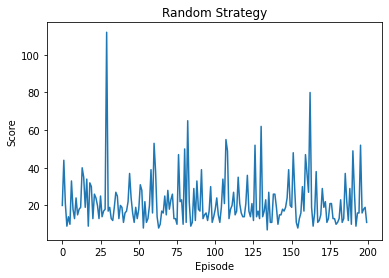

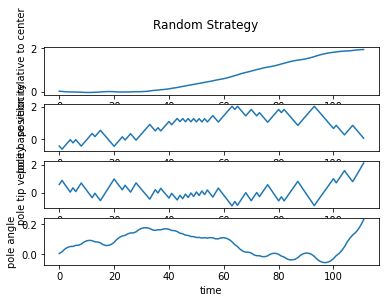

In [5]:
play_game(RandomStrategy, "Random Strategy", episodes)

### Brute Force Strategies
For Brute Force strategies we decided on 4 different ones. Position, Angle, Tip Velocity, and Tip Velocity and Position Strategy. These all track their respective component and moves the pole accordingly. 

#### Position Strategy
If the position of the pole is left of the center, push the pole right or vice versa

In [6]:
class PositionStrategy(BaseStrategy):
    def calculate(self, observation):        
        if (self.is_pole_positioned_right(observation)):
            return self.make_move_left_action()
        else:
            return self.make_move_right_action()

High Score: 65, Average Score: 28.99


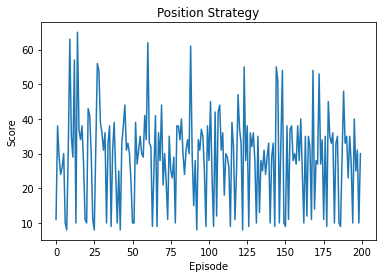

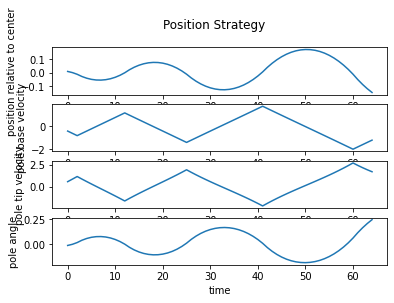

In [7]:
play_game(PositionStrategy, "Position Strategy", episodes)

#### Angle Strategy
If the angle of the pole is left, push the pole left to fix the angle and vice versa

In [8]:
class AngleStrategy(BaseStrategy):
    def calculate(self, observation):        
        if (self.is_pole_angled_left(observation)):
            return self.make_move_left_action()
        else:
            return self.make_move_right_action()

High Score: 65, Average Score: 41.95


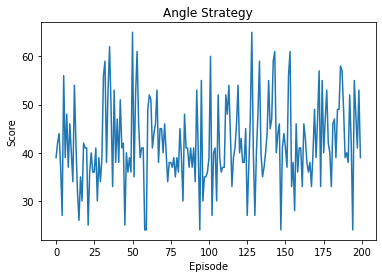

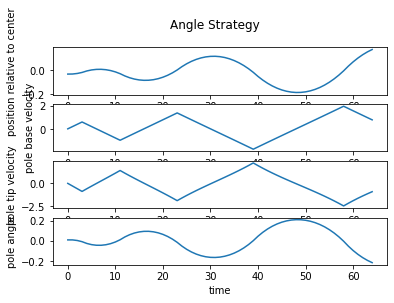

In [9]:
play_game(AngleStrategy, "Angle Strategy", episodes)

#### Tip Velocity Strategy
If the tip of the pole is going left, push the pole left or vice versa

In [10]:
class TipVelocityStrategy(BaseStrategy):
    def calculate(self, observation):        
        if (self.is_pole_tip_velocity_left(observation)):
            return self.make_move_left_action()
        else:
            return self.make_move_right_action()

High Score: 340, Average Score: 201.345


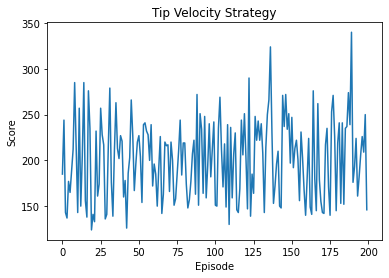

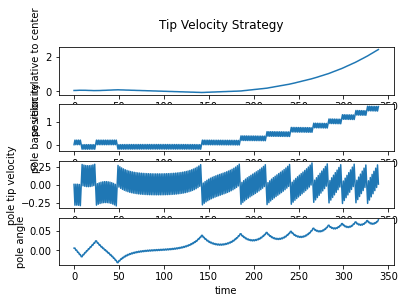

In [11]:
play_game(TipVelocityStrategy, "Tip Velocity Strategy", episodes)

#### Tip Velocity and Position Strategy
If the tip of the pole is going left, push the pole left or vice versa. If the position of the pole is not centered, push the pole back to the center.

In [12]:
class TipVelocityAndPositionStrategy(BaseStrategy):
    count = 0

    def calculate(self, observation):
        self.count = self.count + 1

        if self.count % 2 == 0:
            if (self.is_pole_positioned_right(observation)):
                return self.make_move_left_action()
            else:
                return self.make_move_right_action()

        if (self.is_pole_tip_velocity_left(observation)):
            return self.make_move_left_action()
        else:
            return self.make_move_right_action()

High Score: 228, Average Score: 60.23


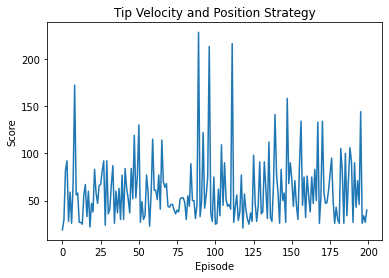

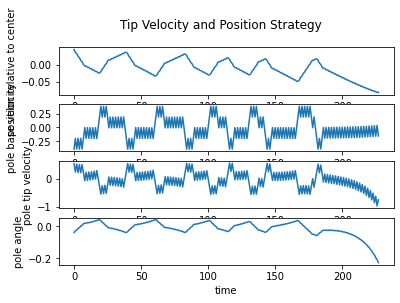

In [13]:
play_game(TipVelocityAndPositionStrategy, "Tip Velocity and Position Strategy", episodes)

### PID Controller Strategy
This strategy utilizes a PID controller in order to try and keep the pole balanced and not fall outside of the given parameters. 

In [14]:
import control
import math

"""
m: mass of pendulum 
M: mass of cart
b: coefficient of friction of the cart (zero in this case)
I: inertia of the pendulum (might be 0?)
l = length of the pendulum 
q = (M+m) * (I+m*(l^2))-((m*l)^2)
closed loop transfer_function = Theta(s)/Force(s) = (-m*l*s)/q)  / ( (s^3) + ((b*(m(l^2) + I)/q)*(s^2) + (((M + m)*g*m*l)/q)*s +  b*m*g*l/q

No significance to values for this model
kd = 1
kp = 1
ki = 1
pid_controller = kd*s + kp + (ki/s)
open_loop_transfer_function = ((-self.m*self.l)/q) / ((s^2) + (((self.M + self.m)*self.g*self.m*self.l)/q))

"""
class PIDStrategy(BaseStrategy):

        def __init__(self):
                self.g = 9.8
                self.m = 0.1
                self.M = 1.0
                self.l = 1.0 # or 0.5?
                self.I = 0

        def pid_controller_pendulum (self, observation):

                error = (180/math.pi) * self.get_pole_angle(observation)
                #amount of deviation from vertical 

                q = (self.M+self.m) * (self.I+self.m*(self.l**2))-((self.m*self.l)**2)
                #q => setting reocurring constants
                open_loop_transfer_function = control.TransferFunction([((-self.m*self.l)/q)], [1, 0, (((self.M + self.m)*self.g*self.m*self.l)/q)])
                
                kd = 1000 
                kp = -100
                ki = 0

                pid_controller = control.TransferFunction([kd, kp, ki], [1, 0])
                #setting up control function
                transfer_function = (open_loop_transfer_function/(1 + open_loop_transfer_function*pid_controller)) 
                #closed loop = open/(1 + (open*control func))                               
                t, force_array = control.impulse_response(transfer_function, X0 = error)
                #gives an impulse and stores how it responds over time
                #IC = starting angle (error), creates a time array (t) and force array, the latter is the actual system output
                force =  force_array[0]
                #only care about first value as it corresponds to our IC

                return force

        def calculate (self, observation):

                force = self.pid_controller_pendulum(observation)

                if (force >= 0):
                        action = self.make_move_left_action()
                        # sol = self.make_more_....()*force
                elif (force < 0):
                        action = self.make_move_right_action()

                return action 

High Score: 67, Average Score: 41.69


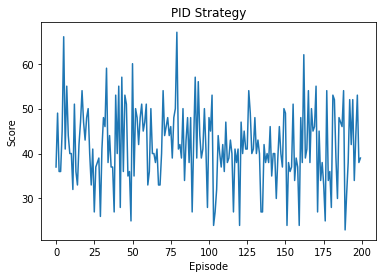

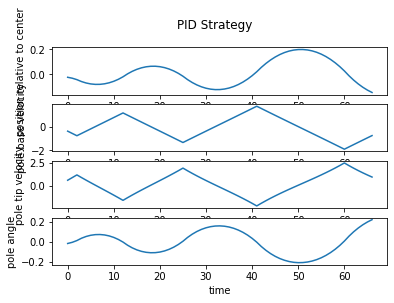

In [15]:
play_game(PIDStrategy, "PID Strategy", episodes)

### DQN Strategy
DQN is a reinforcement learning technique that can be used to solve CartPole. We will split up the strategy in a few parts. First part is to setup a Network class in order to compute the reinforcement learning. Next we will actually solve the game then plot it. Lastly is to have a different way of playing the game due to the reinforcement learning part.

In [27]:
from Logger import Logger, ScoreLogger
import gym
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import rmsprop, Adam
import numpy as np
from collections import deque
from statistics import mean
import h5py

LEARNING_RATE = 1e-3
MAX_MEMORY = 1000000
BATCH_SIZE = 20
GAMMA = 0.95
EXPLORATION_DECAY = 0.995
EXPLORATION_MIN = 0.01

In [28]:
class Network:
    def __init__(self, observation_space, action_space):
        self.action_space = action_space
        self.memory = deque(maxlen=MAX_MEMORY)
        self.exploration_rate = 1.0

        self.model = Sequential()
        self.model.add(Dense(32, input_shape=(observation_space,), activation='relu'))
        self.model.add(Dense(32, activation='relu'))
        self.model.add(Dense(self.action_space, activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(lr=LEARNING_RATE))

    def add_to_memory(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def take_action(self, state):
        if np.random.rand() < self.exploration_rate:
            return random.randrange(0, self.action_space)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def experience_replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        else:
            minibatch = random.sample(self.memory, BATCH_SIZE)
            for state, action, reward, state_next, done in minibatch:
                Q = reward
                if not done:
                    Q = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))
                Q_values = self.model.predict(state)
                Q_values[0][action] = Q
                self.model.fit(state, Q_values, verbose=0)
            self.exploration_rate *= EXPLORATION_DECAY
            self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def get_model(self):
        return self.model

In [29]:
class DQNGameSolver(BaseStrategy):
    def __init__(self, max_episodes, render=False):
        self.max_episodes = max_episodes
        self.logger = Logger()
        self.scorelogger = ScoreLogger()
        self.render = render
        self.highscore = -1
        self.totalscore = 0

        self.score_table = deque(maxlen=400)
        self.average_of_last_runs = None
        self.model = None
        env = gym.make('CartPole-v1')
        observation_space = env.observation_space.shape[0]
        action_space = env.action_space.n
        self.solver = Network(observation_space, action_space)

    def log_score(self, score):
        self.totalscore += score
        self.scorelogger.log(score)

    def log_observation(self, observation, logger):
        logger.log(
             self.get_pole_position(observation),
             self.get_pole_velocity(observation),
             self.get_pole_angle(observation),
             self.get_pole_tip_velocity(observation)
         )

    def plot(self, title=""):
        print("High Score: " + str(self.highscore) + ", Average Score: " + str(self.totalscore/self.max_episodes))
        self.scorelogger.plot(title)
        self.logger.plot(title)
        
    def print_logs(self):
         print(self.logger.get_positions())
         print(self.logger.get_velocities())
         print(self.logger.get_angles())
         print(self.logger.get_tip_velocities())
         print(self.scorelogger.get_scores())

    def play(self):
        env = gym.make('CartPole-v1')
        observation_space = env.observation_space.shape[0]
        action_space = env.action_space.n

        self.model = self.solver.get_model()
        episode = 0
        while episode < self.max_episodes:

            episode += 1
            state = env.reset()
            state = np.reshape(state, [1, observation_space])
            step = 0
            logger = Logger()

            while True:

                step += 1
                if self.render:
                    env.render()
                
                action = self.solver.take_action(state)
                state_next, reward, done, info = env.step(action)

                self.log_observation(state_next, logger)

                if not done:
                    reward = reward
                else:
                    reward = -reward
                state_next = np.reshape(state_next, [1, observation_space])
                self.solver.add_to_memory(state, action, reward, state_next, done)
                state = state_next

                if done:
                    self.log_score(step)
                    if step > self.highscore:
                        self.highscore = step
                        self.logger = logger

                    env.close()
                    break
                self.solver.experience_replay()

In [30]:
def play_dqn_game(title="", episodes=100):
    game = DQNGameSolver(episodes, render)
    game.play()
    game.plot(title)


High Score: 500, Average Score: 114.895


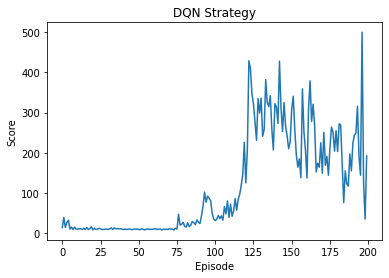

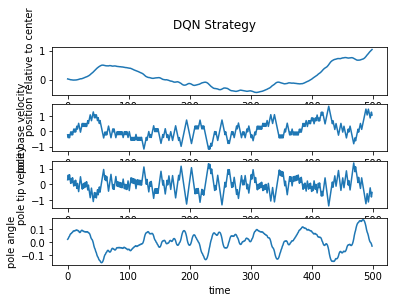

In [31]:
play_dqn_game("DQN Strategy", episodes)

## Conclusions
As we can see there are a lot of ways to solve the CartPole game with varying results from each type of strategy.

## References
DQN Strategy: https://medium.com/@siddharthkale/solving-cartpole-v1-4be909b7c2c6